<b> Functions <b>

In [2]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el

    
    return negat


<b> Parameters <b>

In [82]:
# wc= 1  # frequency of the cavity photons
# wa= 0.1  # transition frequency of the qubits


# N = 2      # number of cavity fock states (N-1 photons inn the cavity)
# n_th_a = 0.0           # temperature in frequency units
# g = 0.05*wc # coupling strength


# #time settings
# ti = 0 #initial time
# tf = 40 #final time
# steps = 1001 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps

wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits


N = 2      # number of cavity fock states (N-1 photons inn the cavity)
n_th_a = 0.0           # temperature in frequency units
g = 10**(6)*2*np.pi*50 # coupling strength
theta = 0.8

#LONG-TIME SETTINGS
ti = 0 #initial time
tf = 10**(-9)*2 #final time
steps = 2000 #number of steps
tau_list = np.linspace(ti,tf,steps) # vector of time steps

# # SHORT-TIME EVOLUTION TIME SETTINGS
# #time settings
# ti = 0 #initial time
# tf = 10**(-10)*1.5 #final time
# steps = 114 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps


# Averaged coupling

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


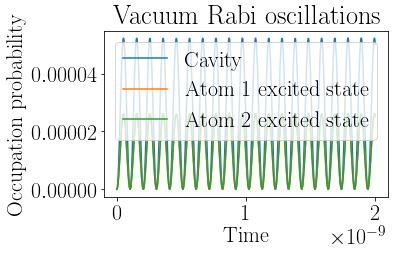

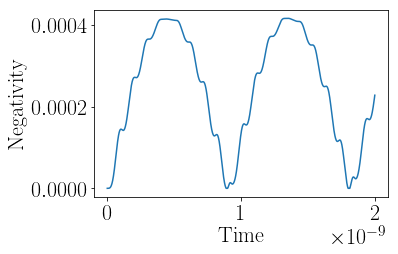

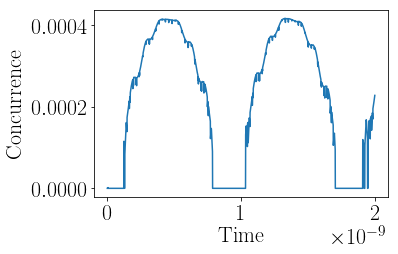

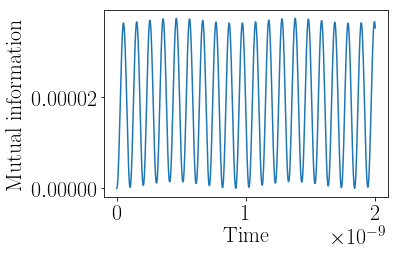

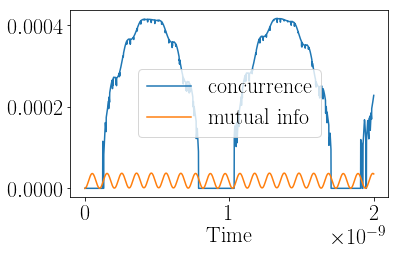

In [43]:


# intial state (ground state)
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0))    # start with 0 excited atom and 0 photons



# density matrix
rho0 = ket2dm(psi0) #turns ket into a density matrix




# operators
a  = tensor(destroy(N), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation





# Rabi model Hamiltonian for two atoms and a cavity mode for the average coupling
    
H = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2  + g/2*(a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag()) + g/2*(a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())

# #only anti-tavis cummings contributions
# H = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 + g*(a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())

# #only anti-tavis cummings contributions in the INTERACTION PIC
# H = 0.99*g*(a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag()) + 0.01*g*(a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag())


#list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
c_op_list = [] # no dissipation
    

#solve master equation
output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 

result = mesolve(H, rho0, tau_list, c_op_list)  #stores density matrix operator changing in time


# plot excitation probabilities of photons and atoms
plt.plot(tau_list, output.expect[0], label="Cavity")
plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations');
plt.show()


#initialize entanglement measures vectors
neg = np.zeros(steps) #negativity

mut = np.zeros(steps) #mutual information

conc = np.zeros(steps) #concurrence

x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)

for i in range(steps):
    states = result.states[i]*result.states[i].dag() # creates density matrix at each time 

    rhoqub = states.ptrace(x) # traces over the photonic degrees of freedom to obtain the density matrix of the qubits
    
    conc[i] = concurrence(rhoqub) # computes concurrence between qubits 
    
    mut[i] = entropy_mutual(rhoqub,0,1) #computes mutual information between the qubits
    
    neg[i] = nega(rhoqub, 0) #computes negativity between a qubit and the rest of the system
    

np.save('data/conc_avg_2q_num_an', conc)
np.save('data/mut_avg_2q_num_an', mut)
np.save('data/neg_avg_2q_num_an', neg)

    
    
#plot negativity
plt.plot(tau_list,neg)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()    
    
#plot concurrence
plt.plot(tau_list,conc)
plt.xlabel('Time')
plt.ylabel('Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut)
plt.xlabel('Time')
plt.ylabel('Mutual information')
plt.show()

#plot conc/mut
plt.plot(tau_list,conc, label = 'concurrence')
plt.plot(tau_list,mut, label = 'mutual info')
plt.xlabel('Time')
plt.legend()
plt.show()









# Dynamical coupling

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


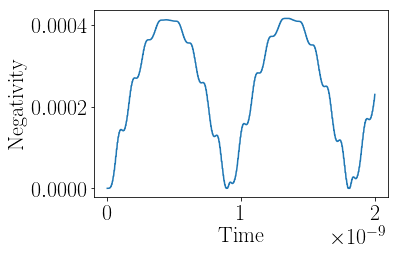

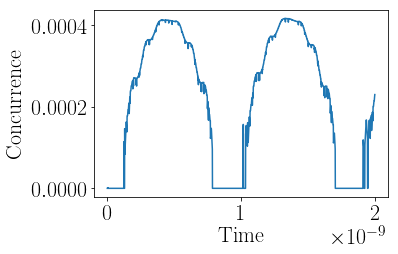

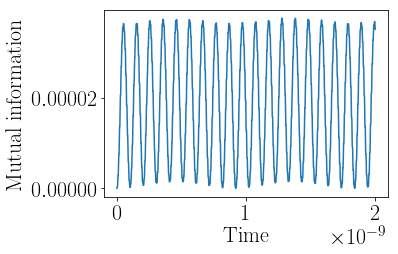

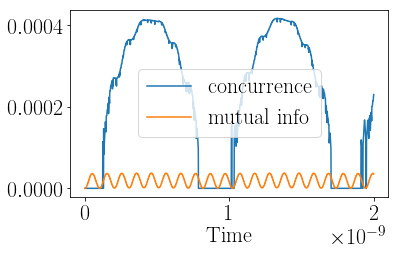

In [83]:
# #time settings
# ti = 0 #initial time
# tf = 10**(-10)*2 #final time
# steps = 1500 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps

T= 2*np.pi/(30*wa)

# intial state (ground state)
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0))    # start with 0 excited atom and 0 photons



# density matrix
rho0 = ket2dm(psi0) #turns ket into a density matrix




# operators
a  = tensor(destroy(N), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation


#list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
c_op_list = []

    



# Rabi model Hamiltonian for two atoms and a cavity mode for time dependent coupling

# high freq modulation
def H1_coeff(t,args):
    coeff = g*heaviside(np.cos((30*wa)*t))
    return coeff

# def H1_coeff(t,args):
#     coeff = 0
#     for k in range(800):
#         coeff += g/2*(heaviside(t-k*T) -2*(heaviside(t-(2*k+1)*T/2)) + heaviside(t-(k+1)*T)  )
    
    
#     if(t>0):
#         coeff = coeff + g/2
    
#     return 2*coeff

# # single switch
# def H1_coeff(t,args):
#     coeff = g*heaviside(t)
#     return coeff

H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2

H1 = (a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())


H = [H0,[H1,H1_coeff]]



    

#solve master equation
# output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 

result = mesolve(H, rho0, tau_list, c_op_list)  #stores density matrix operator changing in time


# # plot excitation probabilities of photons and atoms
# plt.plot(tau_list, output.expect[0], label="Cavity")
# plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
# plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Occupation probability')
# plt.title('Vacuum Rabi oscillations');
# plt.show()


#initialize entanglement measures vectors
neg_2 = np.zeros(steps) #negativity

mut_2 = np.zeros(steps) #mutual information

conc_2 = np.zeros(steps) #concurrence

x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)

for i in range(steps):
    states = result.states[i]*result.states[i].dag() # creates density matrix at each time 

    rhoqub = states.ptrace(x) # traces over the photonic degrees of freedom to obtain the density matrix of the qubits
    
    conc_2[i] = concurrence(rhoqub) # computes concurrence between qubits 
    
    mut_2[i] = entropy_mutual(rhoqub,0,1) #computes mutual information between the qubits
    
    neg_2[i] = nega(rhoqub, 0) #computes negativity between a qubit and the rest of the system
    

np.save('data/conc_dyn_2q_num_an', conc_2)
np.save('data/mut_dyn_2q_num_an', mut_2)
np.save('data/neg_dyn_2q_num_an', neg_2)
    
    
#plot negativity
plt.plot(tau_list,neg_2)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()    
    
#plot concurrence
plt.plot(tau_list,conc_2)
plt.xlabel('Time')
plt.ylabel('Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut_2)
plt.xlabel('Time')
plt.ylabel('Mutual information')
plt.show()

#plot conc/mut
plt.plot(tau_list,conc_2, label = 'concurrence')
plt.plot(tau_list,mut_2, label = 'mutual info')
plt.xlabel('Time')
plt.legend()
plt.show()




<b> Analytical solutions <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


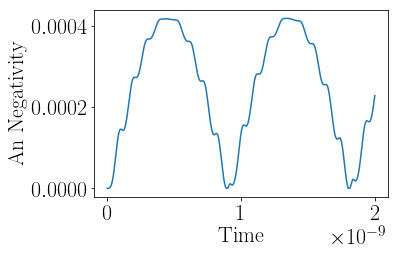

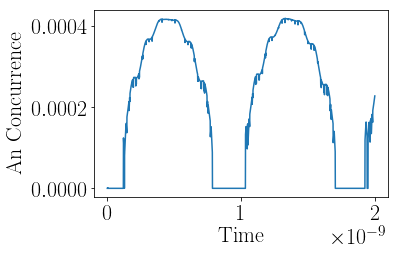

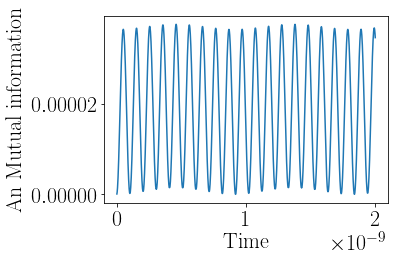

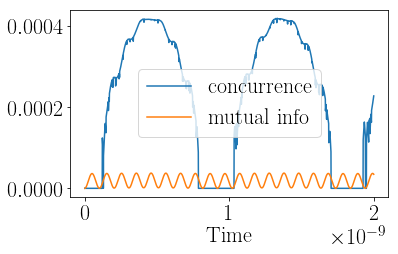

In [84]:
# analitycal results
cont = 0

conc_an = np.zeros(steps)

neg_an = np.zeros(steps) #negativity

mut_an = np.zeros(steps) #mutual information


for t in tau_list:

    
#     #state found analytically (without g/2)
#     psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*tensor(basis(N,1), basis(2,1), basis(2,0)) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*tensor(basis(N,1), basis(2,0), basis(2,1)) + (g**2)/(wa+wc)*(2*((2*wa)*(-np.exp(-complex(0,1)*(wc+wa)*t))+(wc+wa)*(np.exp(-complex(0,1)*(2*wa)*t)-1)+2*wa)/(2*wa*(2*wa-(wa+wc))))*tensor(basis(N,0), basis(2,1), basis(2,1)) + 2*(g**2)/(wc+wa)*(complex(0,1)*(wc+wa)*t + np.exp(-complex(0,1)*(wc+wa)*t) -1)/(wc+wa)*tensor(basis(N,0), basis(2,0), basis(2,0)) 
#     psi0_an = psi0_an.unit()

#     # state found analytically (with g/2)
    
#     a11 = g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)/2
#     a12 = a11
    
    
#     a21 = (g**2/2)/(wc+wa)*(complex(0,1)*(wc+wa)*t + np.exp(-complex(0,1)*(wc+wa)*t) -1)/(wc+wa)
#     a22 = (g**2)/(wa+wc)*(((2*wa)*(-np.exp(-complex(0,1)*(wc+wa)*t))+(wc+wa)*(np.exp(-complex(0,1)*(2*wa)*t)-1)+2*wa)/(4*wa*(wa-wc)))

    
#     psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + a11*tensor(basis(N,1), basis(2,1), basis(2,0)) + a12*tensor(basis(N,1), basis(2,0), basis(2,1)) + a22*tensor(basis(N,0), basis(2,1), basis(2,1)) + a21*tensor(basis(N,0), basis(2,0), basis(2,0)) 
#     psi0_an = psi0_an.unit()

# #general states (T=0 for high frequency limit)

    T=2*np.pi/(30*wa)
    

    a11 = -g/(2*(wc+wa))*(1 - (2*np.exp(-complex(0,1)*(wc+wa)*t))/(1+np.exp(complex(0,1)*(wc+wa)*T/2)) )
    a12 = a11

    
# #     #right sol
    
    a21 = (g**2*(2*np.exp(-complex(0,1)*t*(wa + wc)) + complex(0,1)*(2*t + T)*(wa + wc) - 2*(1/(np.cos((T/4*(wa + wc)))))**2 - (2*complex(0,1))*(1 + np.exp((-complex(0,1))*t*(wa + wc)))*np.tan((T*(wa + wc))/4)))/(4*(wa + wc)**2)

#     a22 = (g**2)/4*(1/(wa**2 + wa*wc) + (2*complex(0,1)*np.exp(-complex(0,1)*t*(wa+wc)) + (np.tan((T*(wa + wc))/4) + complex(0,1) ) )/(wa**2 - wc**2) + ( np.exp(-2*complex(0,1)*t*wa)*(wa+wc-2*complex(0,1)*wc*np.tan(T*wa/2) +2*wa*np.tan(T/4*(wc-wa))*(complex(0,1)+np.tan(T/4*(wa+wc))) ) )/(wa*(wa-wc)*(wa+wc)) )

    b0 = 1/(wa**2 + wa*wc)
    b1 = 2*complex(0,1)*np.exp(-complex(0,1)*t*(wa+wc))*(complex(0,1) + np.tan(T/4*(wa+wc)))/(wa**2 - wc**2)
    b2 = np.exp(-2*complex(0,1)*t*wa)*(wa+wc)/(wa*(wa-wc)*(wa+wc))
    b3 = np.exp(-2*complex(0,1)*t*wa)*(-2*complex(0,1)*wc*np.tan(T*wa/2))/(wa*(wa-wc)*(wa+wc))
    b4 = np.exp(-2*complex(0,1)*t*wa)*( 2*wa*np.tan(T*(wc-wa)/4)*(complex(0,1)+np.tan(T*(wa+wc)/4))  )/(wa*(wa-wc)*(wa+wc))
    
    a22 = (g**2)/4*(b0+b1+b2+b3+b4)  
    
    #state found analytically
    psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + (a11)*tensor(basis(N,1), basis(2,1), basis(2,0)) + (a12)*tensor(basis(N,1), basis(2,0), basis(2,1)) + a21*tensor(basis(N,0), basis(2,0), basis(2,0)) + a22*tensor(basis(N,0), basis(2,1), basis(2,1)) 
    psi0_an = psi0_an.unit()




    
#     #state found analytically using only counter rotating terms in H
#     psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*tensor(basis(N,1), basis(2,1), basis(2,0)) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*tensor(basis(N,1), basis(2,0), basis(2,1)) + 2*(g**2)/(wc+wa)*(complex(0,1)*(wc+wa)*t + np.exp(-complex(0,1)*(wc+wa)*t) -1)/(wc+wa)*tensor(basis(N,0), basis(2,0), basis(2,0)) 
#     psi0_an = psi0_an.unit()
    
    
    #density matrix
    rho0_an = ket2dm(psi0_an)

    x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)
    rhoqub_an = rho0_an.ptrace(x)

    conc_an[cont] = concurrence(rhoqub_an)
    
    mut_an[cont] = entropy_mutual(rhoqub_an,0,1) #computes mutual information between the qubits
    
    neg_an[cont] = nega(rhoqub_an, 0) #computes negativity between a qubit and the rest of the system
    
    cont += 1

np.save('data/conc_ana_2q_num_an', conc_an)
np.save('data/mut_ana_2q_num_an', mut_an)
np.save('data/neg_ana_2q_num_an', neg_an)

#plot negativity
plt.plot(tau_list,neg_an)
plt.xlabel('Time')
plt.ylabel('An Negativity')
plt.show()    
    
#plot concurrence
plt.plot(tau_list,conc_an)
plt.xlabel('Time')
plt.ylabel('An Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut_an)
plt.xlabel('Time')
plt.ylabel('An Mutual information')
plt.show()

#plot conc/mut
plt.plot(tau_list,conc_an, label = 'concurrence')
plt.plot(tau_list,mut_an, label = 'mutual info')
plt.xlabel('Time')
plt.legend()
plt.show()


<b> Compare analytical and numerical results <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


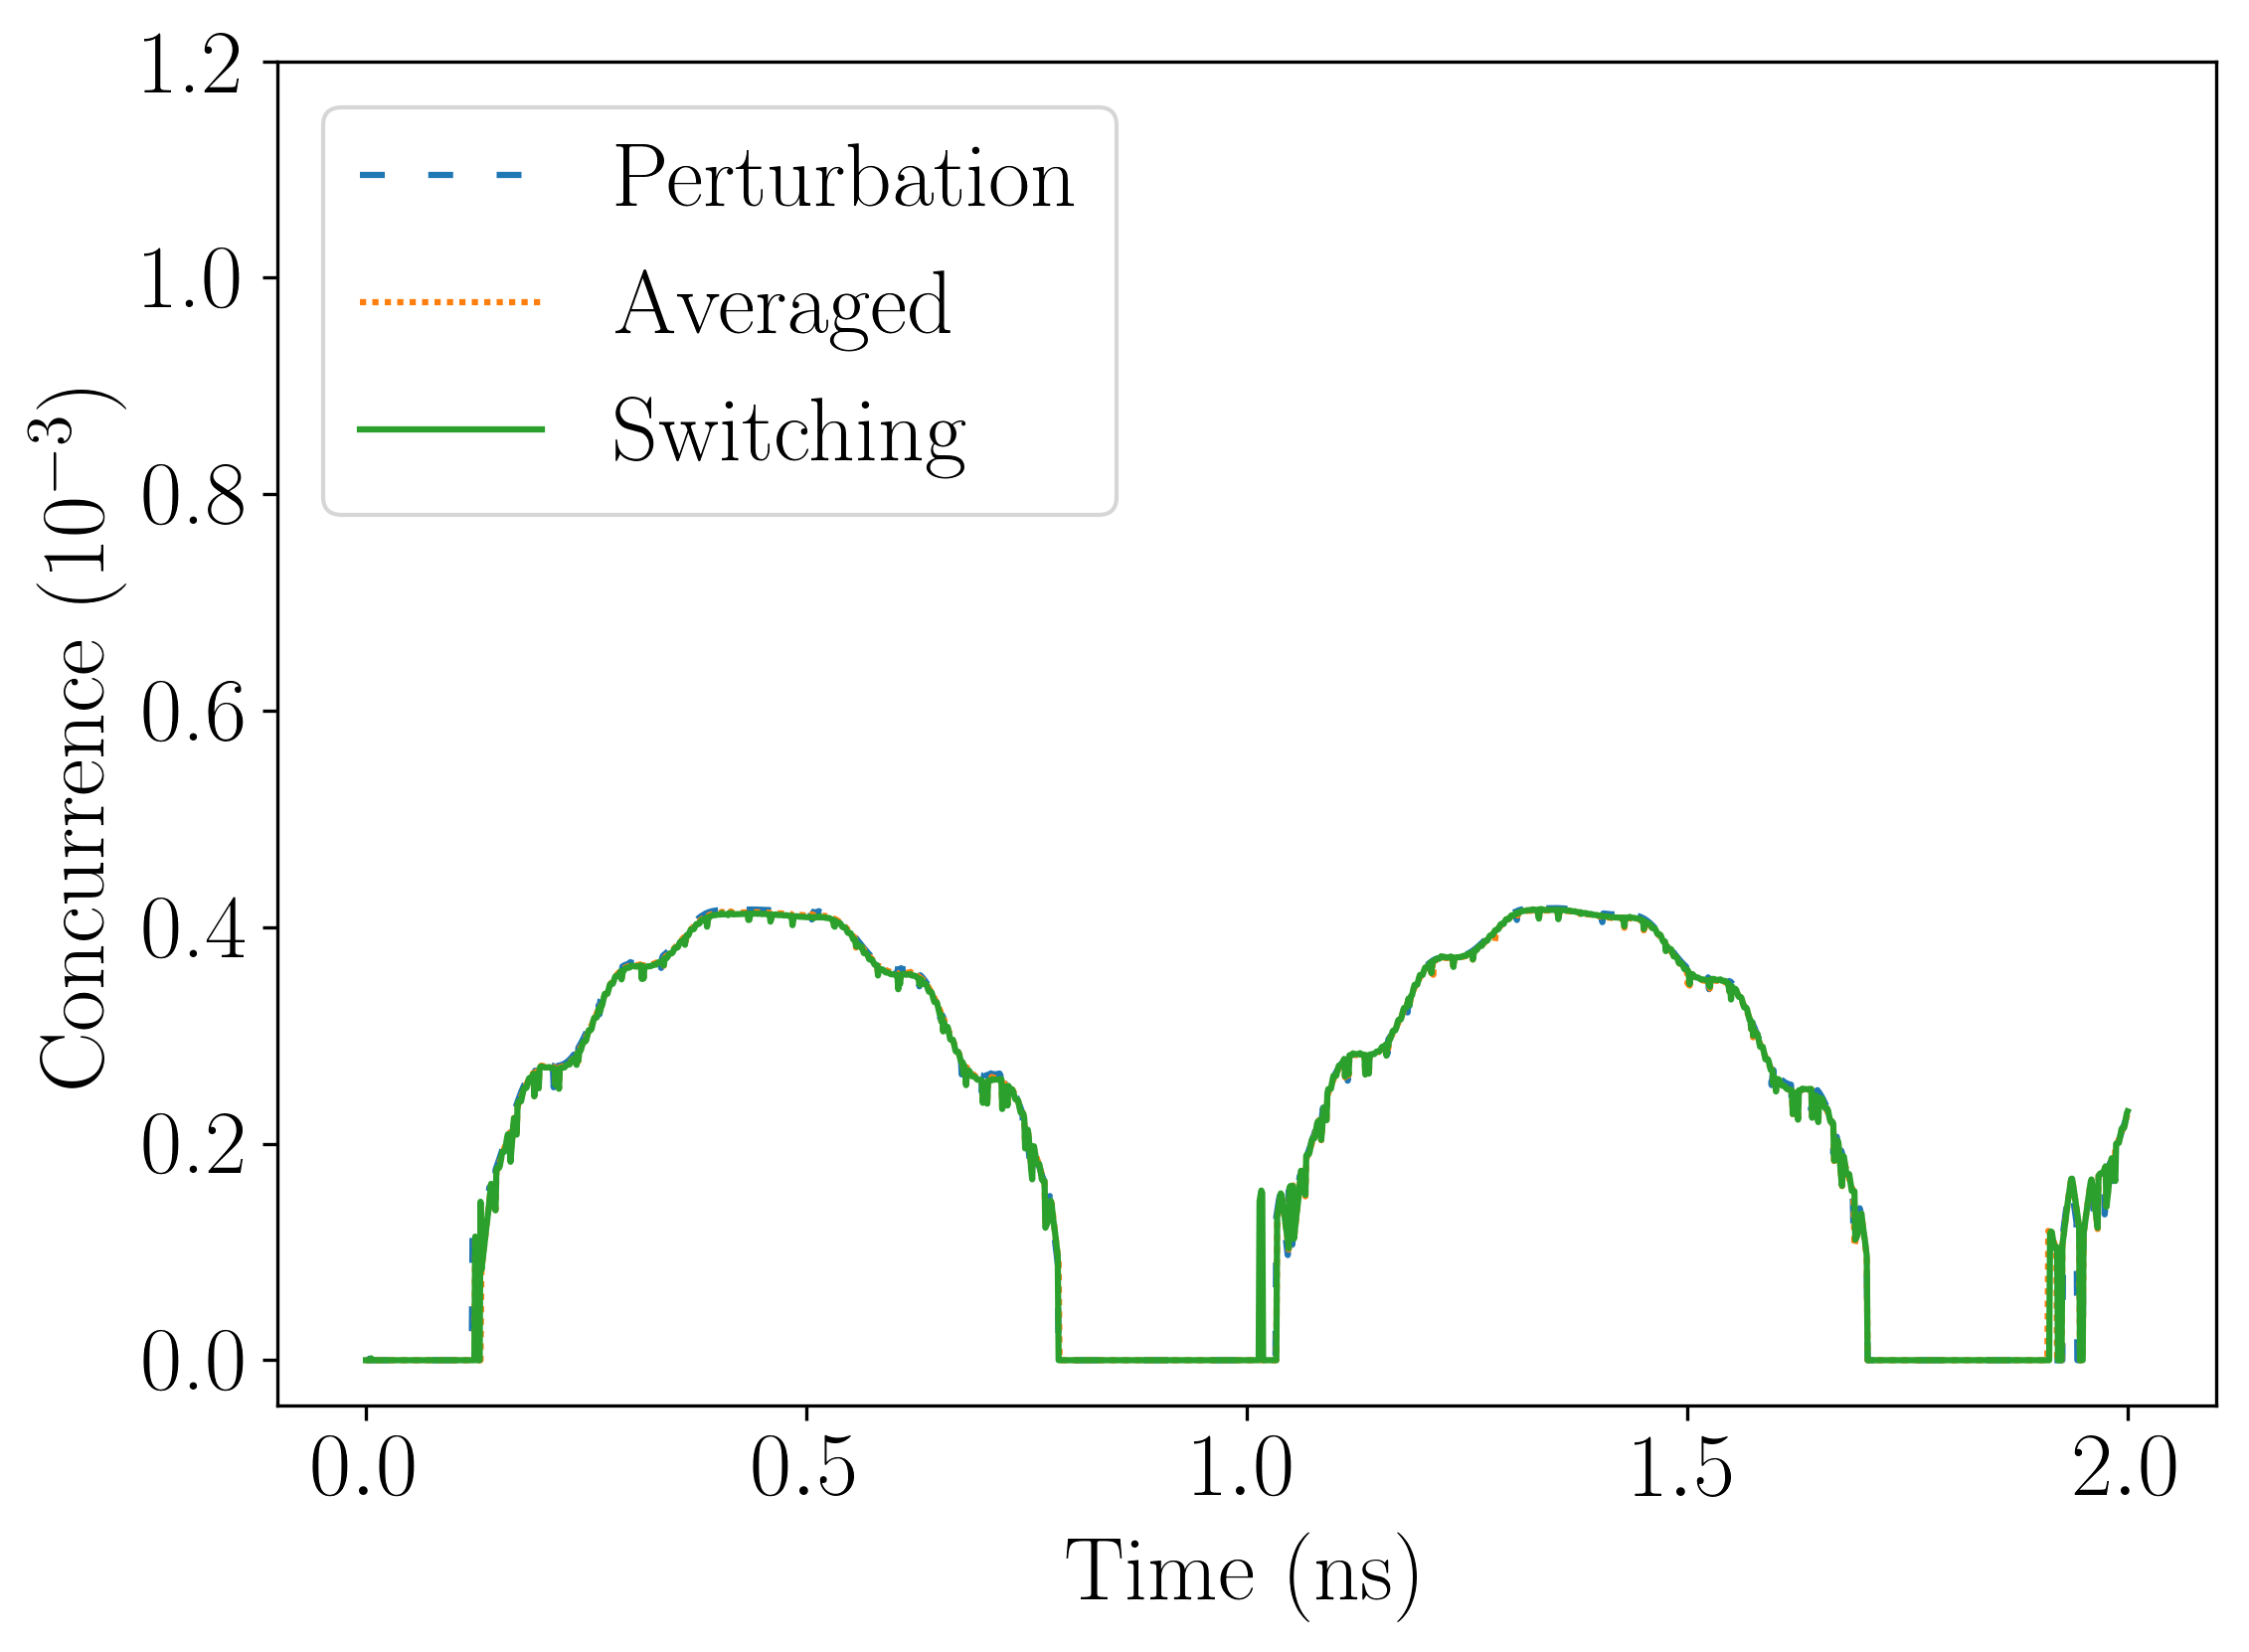

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


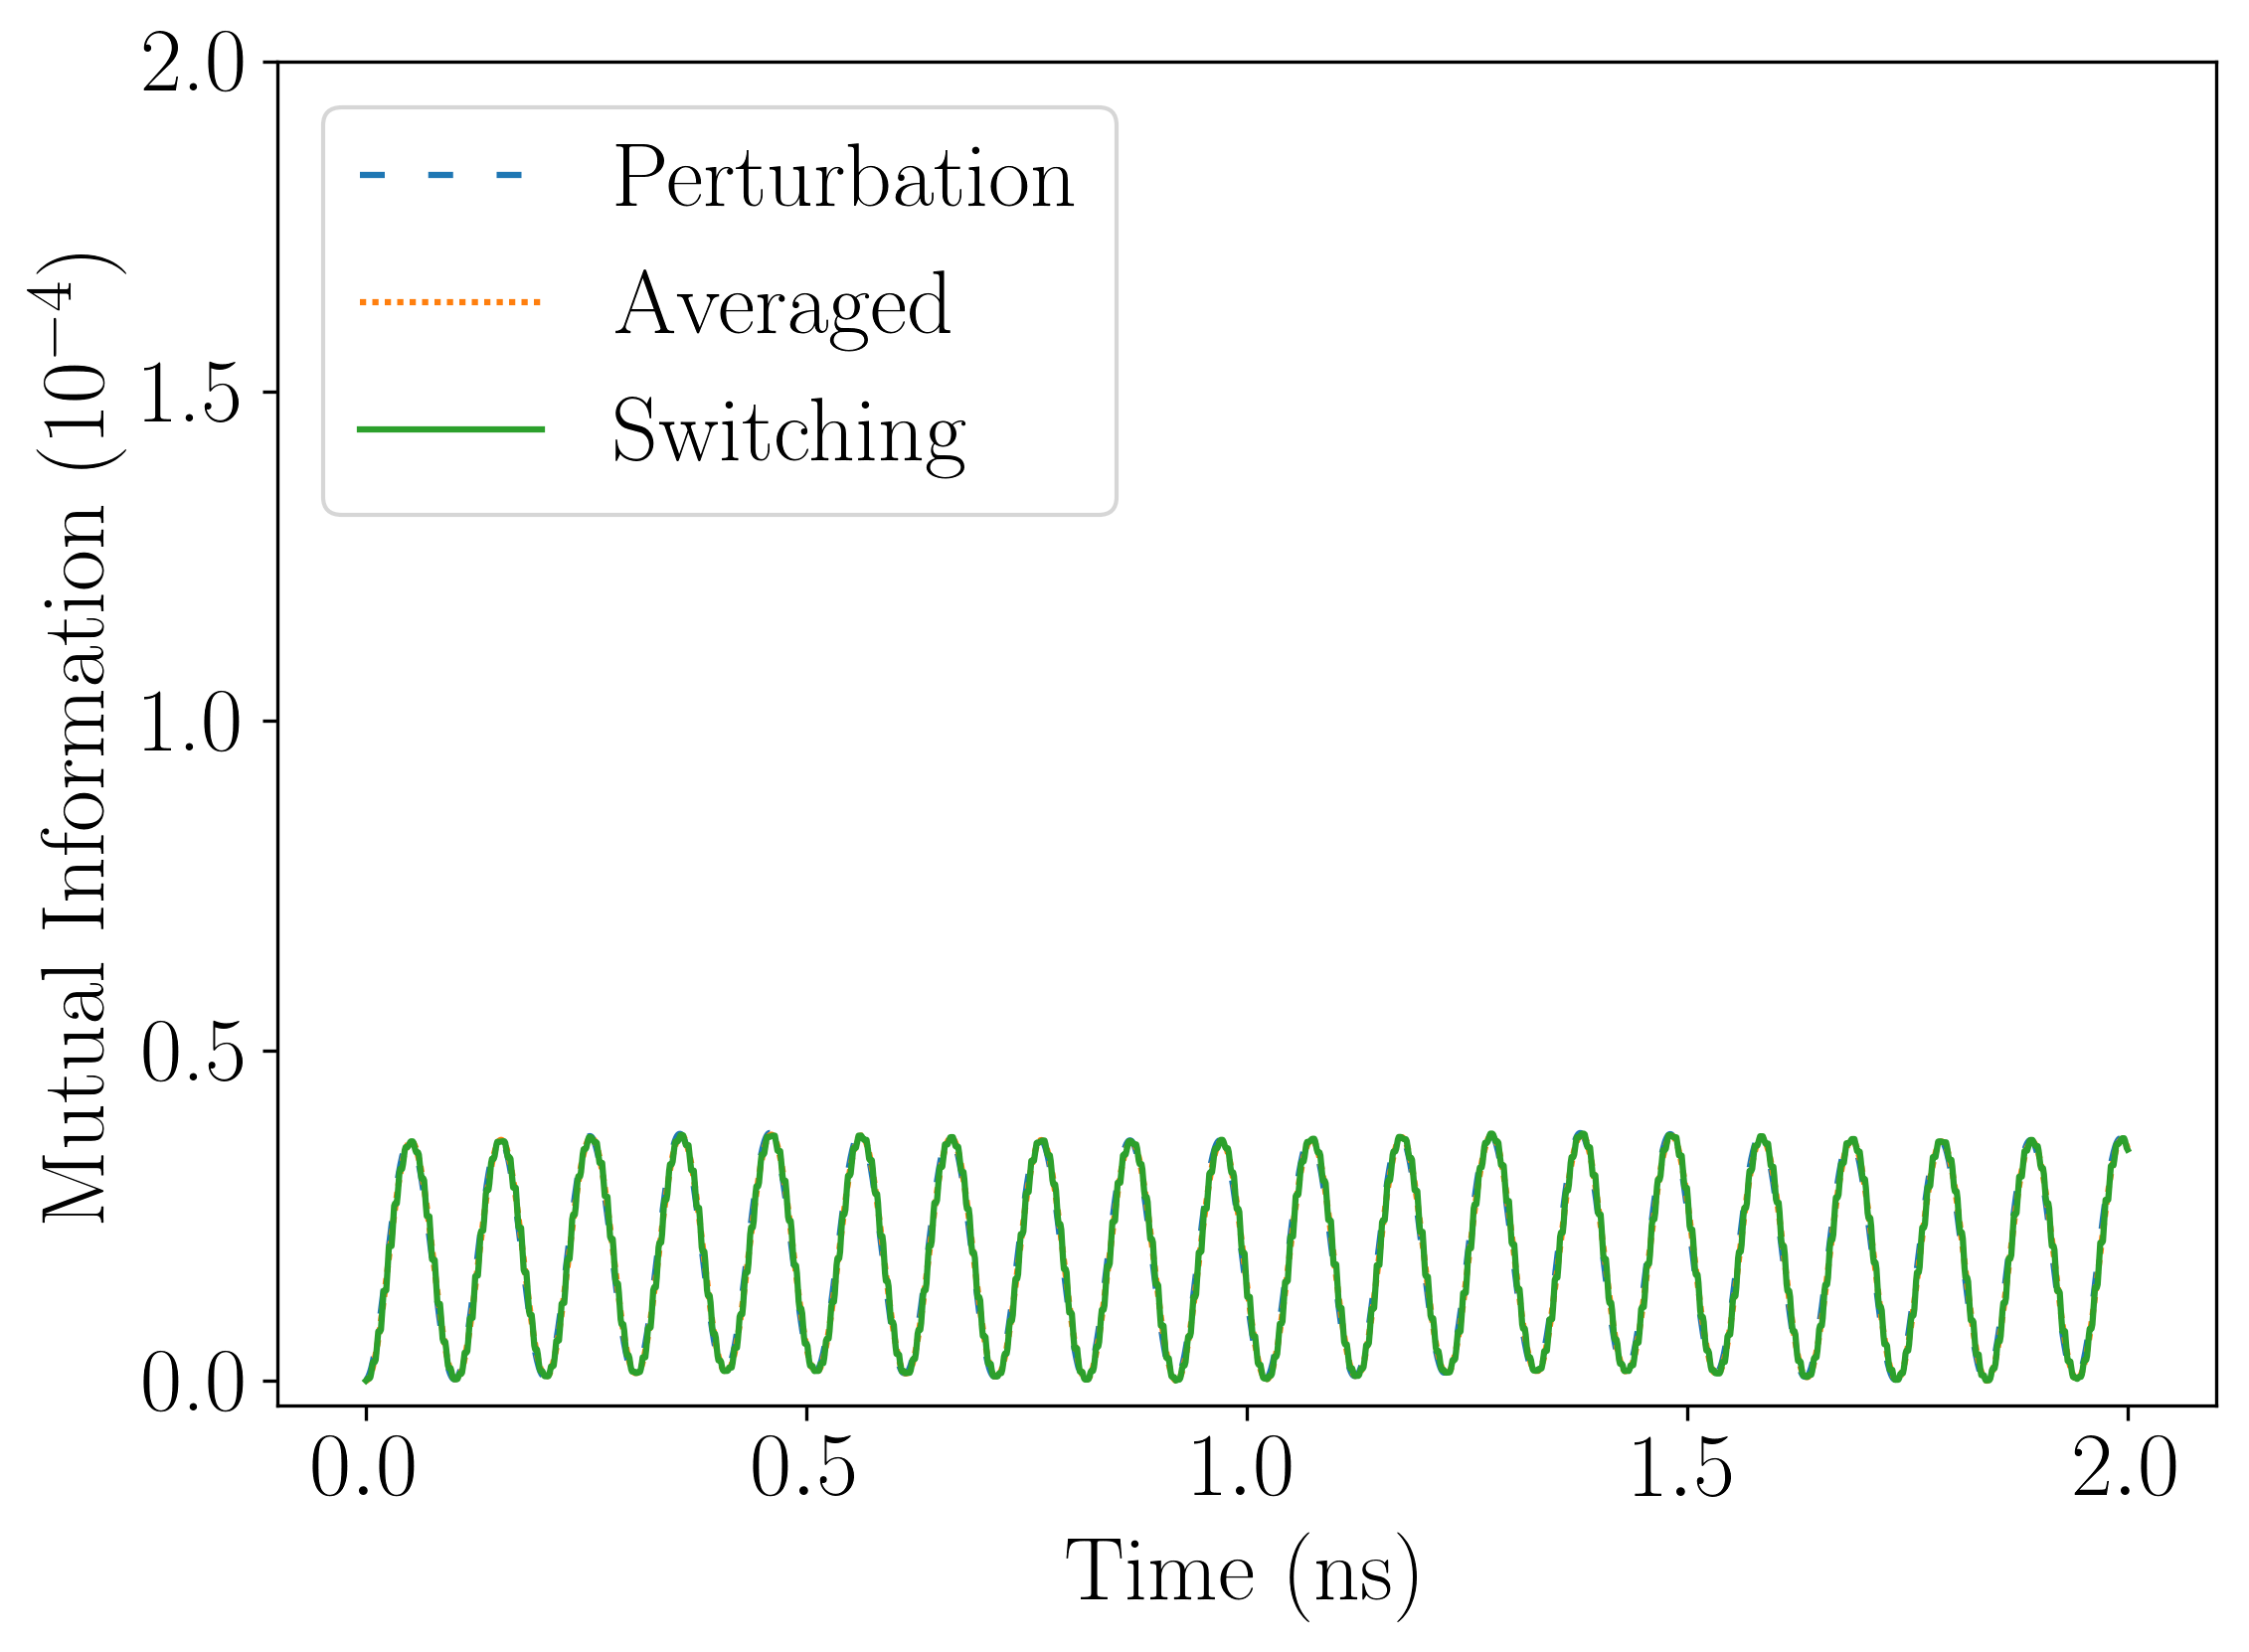

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


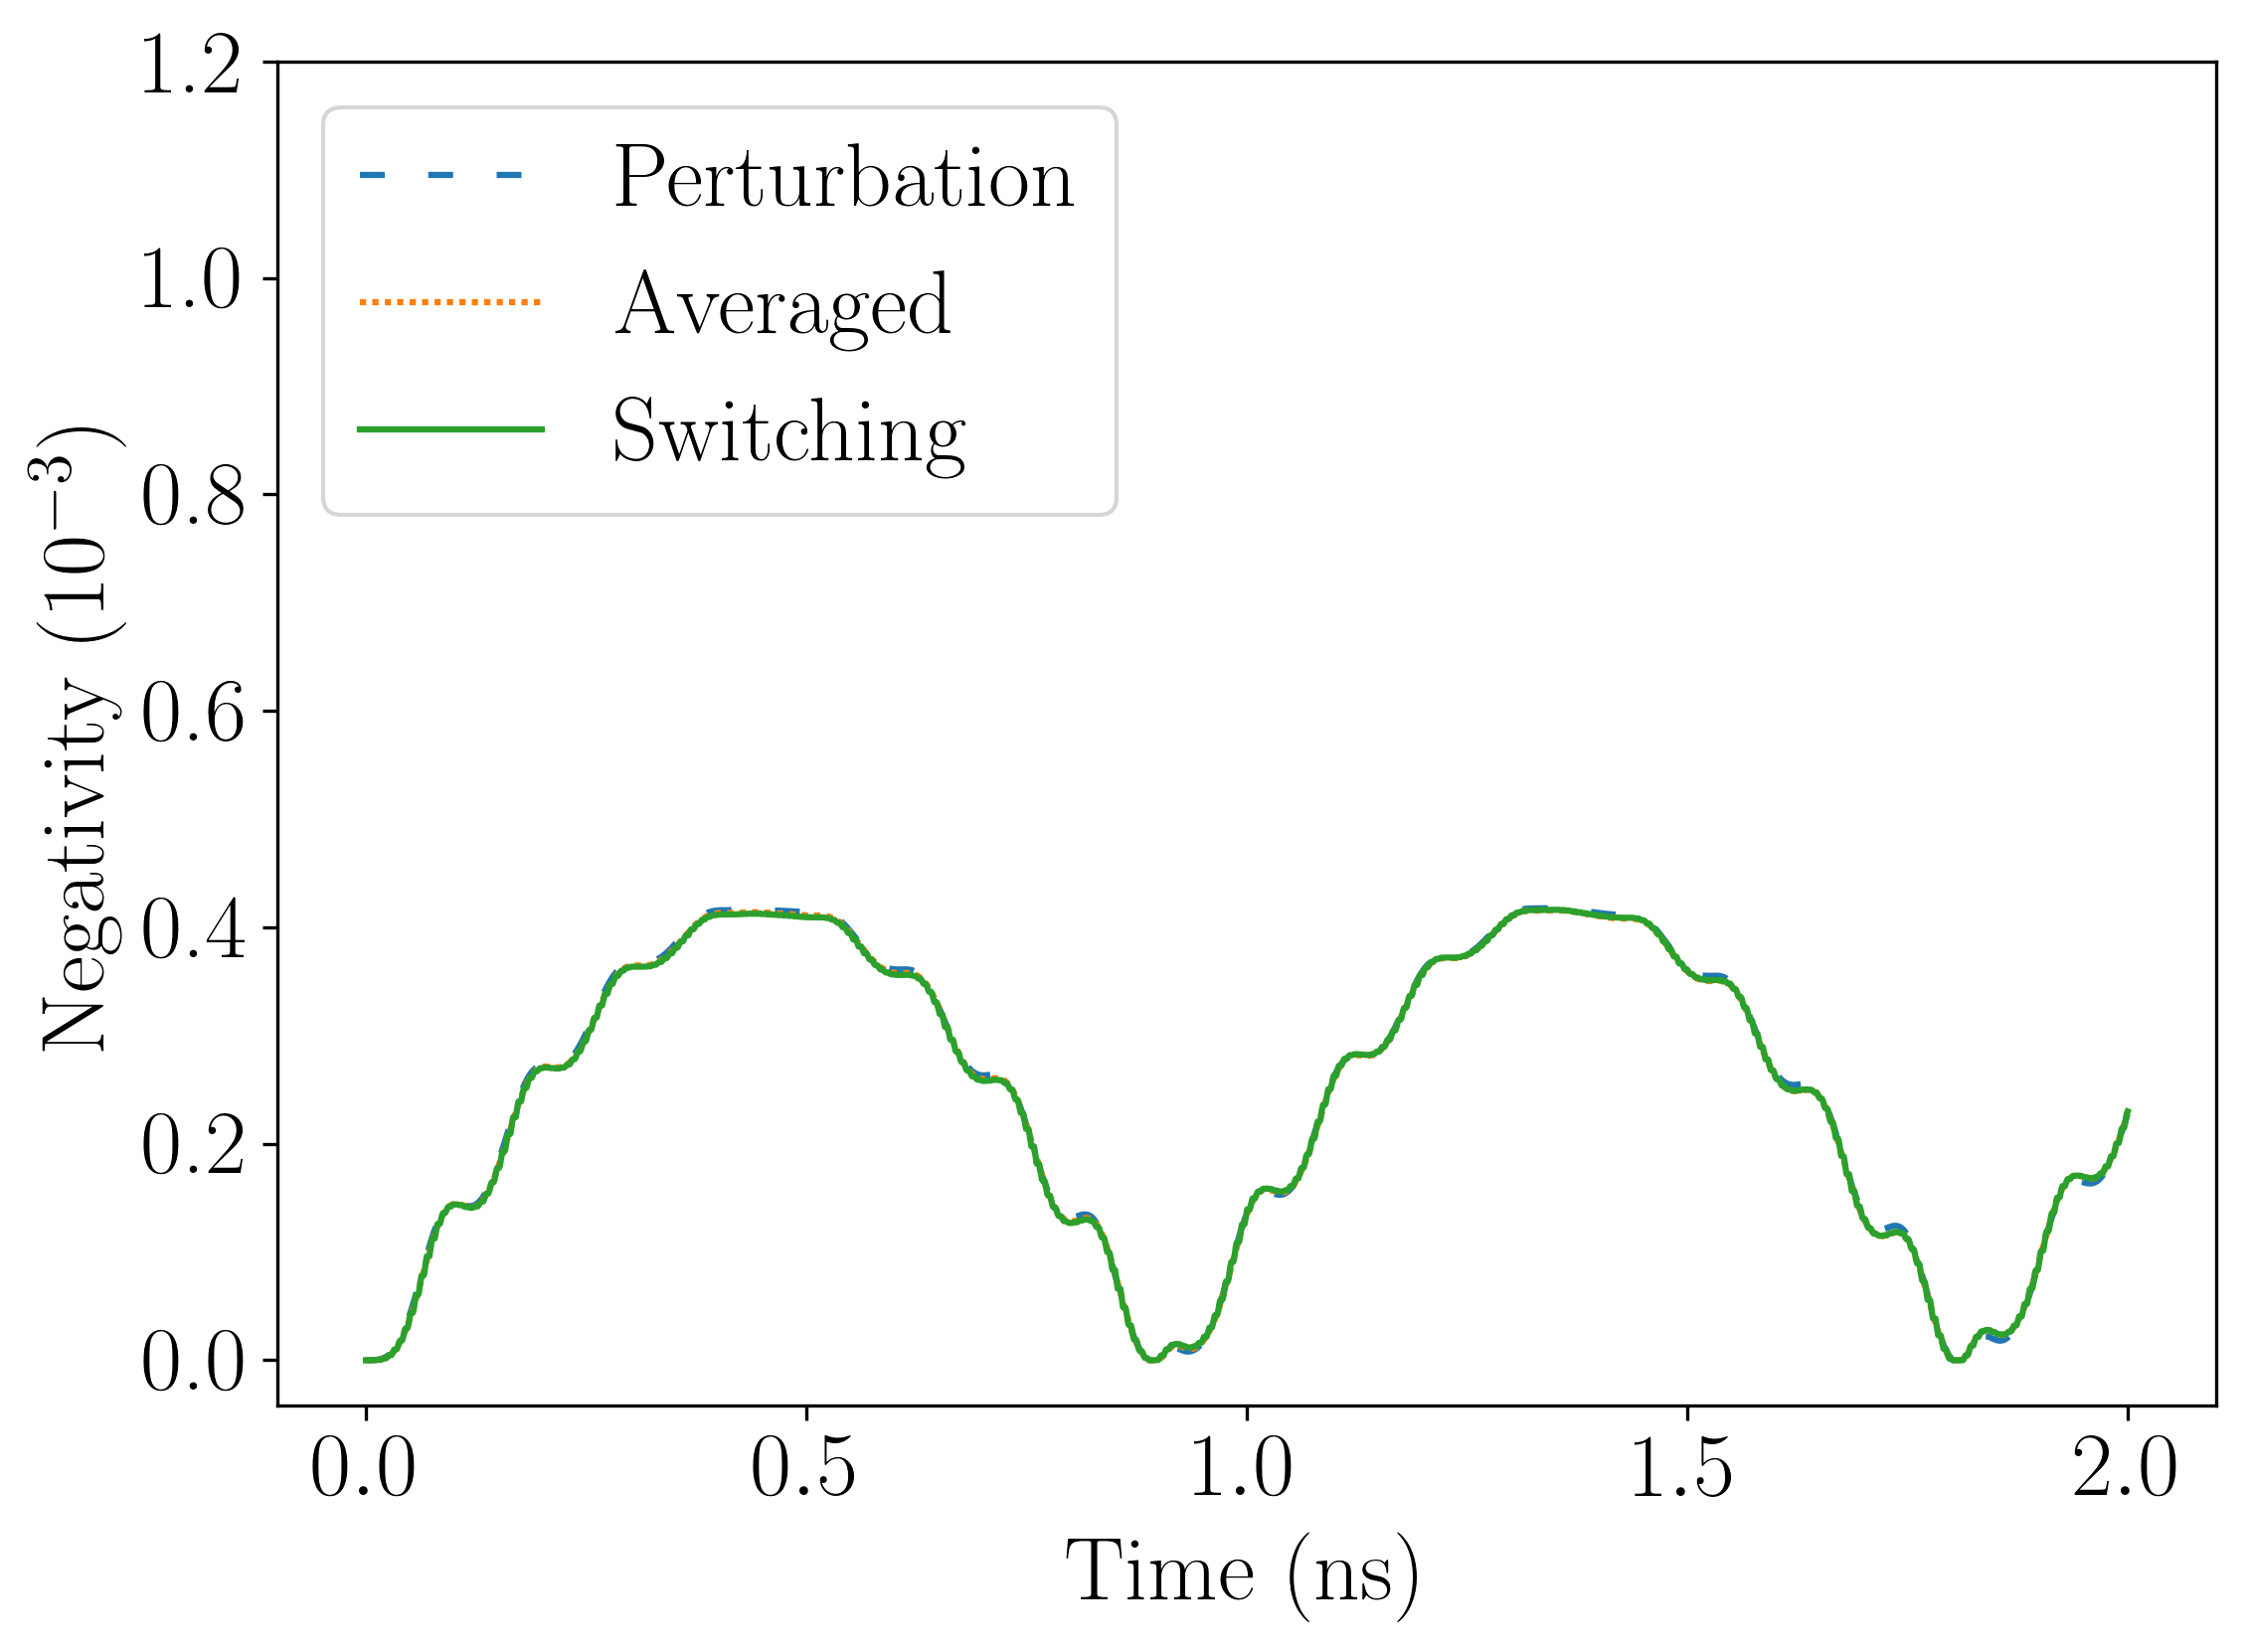

In [85]:
#changes plot parameters
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')






#compare analytical and numerical results for the concurrence

c_an = np.load("data/conc_ana_2q_num_an.npy")
c = np.load("data/conc_avg_2q_num_an.npy")
c_2 = np.load("data/conc_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, c_an*10**3,dashes=[4, 7], label = 'Perturbation')
plt.plot(tau_list*10**9, c*10**3,dashes=[1, 1], label = 'Averaged')
plt.plot(tau_list*10**9, c_2*10**3, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22)
plt.ylabel(r' Concurrence ($10^{-3}$)', fontsize = 22)
# plt.ylabel(r' Concurrence')
plt.legend(loc=2)
ymin = -0.1*max(conc_2*10**3)
ymax = max(conc_2*10**3)+1.5*max(conc_2*10**3)
plt.ylim((ymin,ymax)) # sets limit for y-axis

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('concurrence_2q_num_an.eps', dpi = 300)
plt.show()



#compare analytical and numerical results for the mutual

m_an = np.load("data/mut_ana_2q_num_an.npy")
m = np.load("data/mut_avg_2q_num_an.npy")
m_2 = np.load("data/mut_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, m_an*10**4,dashes=[4, 7], label = 'Perturbation')
plt.plot(tau_list*10**9, m*10**4,dashes=[1, 1], label = 'Averaged')
plt.plot(tau_list*10**9, m_2*10**4, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22 )
plt.ylabel(r' Mutual Information ($10^{-4}$)', fontsize = 22)
# plt.ylabel(r' Mutual information')
plt.legend(loc=2)
ymin = -0.1*max(mut_2*10**4)
ymax = max(2*mut_2*10**4)+1.5*max(2*mut_2*10**4)
plt.ylim((ymin,ymax)) # sets limit for y-axis

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('mutual_info_2q_num_an.eps', dpi = 300)
plt.show()




#compare analytical and numerical results for the negativity
n_an = np.load("data/neg_ana_2q_num_an.npy")
n = np.load("data/neg_avg_2q_num_an.npy")
n_2 = np.load("data/neg_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, n_an*10**3,dashes=[4, 7], label = 'Perturbation')
plt.plot(tau_list*10**9, n*10**3,dashes=[1, 1], label = 'Averaged')
plt.plot(tau_list*10**9, n_2*10**3, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22 )
plt.ylabel(r' Negativity ($10^{-3}$)', fontsize = 22)
# plt.ylabel(r' Negativity')
plt.legend(loc=2)
ymin = -0.1*max(neg_2*10**3)
ymax = max(neg_2*10**3)+1.5*max(neg_2*10**3)
plt.ylim((ymin,ymax)) # sets limit for y-axis
 
locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('negativity_2q_num_an.eps', dpi = 300)
plt.show()







In [8]:
print('switching time',1/(20*wa))
print('time step',2*10**-9/5000)
print('cavity round-trip time',np.pi/(wc))

switching time 1.4630901185134708e-12
time step 4e-13
cavity round-trip time 1.1512779184895233e-10
